In [ ]:
#@markdown #CMS Diversity Data: Statistics Analysis
#@markdown ###Comparing the USCMS to the full CMS collaboration
#@markdown This notebook will visualize and report the diversity statistics for 
#@markdown the specified country(s) relative to the full CMS collaboration.  The
#@markdown statistics can be filtered by year, gender, role, activity and authorship.
#@markdown ### Import `python` libraries

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import ipywidgets as widgets
from scipy import stats

from google.colab import drive
drive.mount( '/content/drive' )

%cd /content/drive/My Drive/Colab Notebooks/USCMS-diversity-analysis-main/USCMS-diversity-analysis-main

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/USCMS-diversity-analysis-main/USCMS-diversity-analysis-main


In [3]:
#@markdown Import the `json` data file `json_analysis.json`.  This file is created
#@markdown from `combine_json_colab.ipynb` which should be run before this notebook.
#@markdown Display the available years in the `json` file.

with open( "Data/json_analysis.json" ) as json_file:
    data = json.load( json_file )
print( ">> json_analysis.json contains years: {}".format( list( data.keys() ) ) )

>> json_analysis.json contains years: ['2015', '2016', '2017', '2018', '2019', '2020']


In [4]:
#@markdown Distinguish between the USCMS institutes and full CMS Collaboration 
#@markdown institutes into separate datasets.
with open( "Data/institutes_new.json" ) as json_file:
    institutes = json.load( json_file )

us_institutes = [ institute["code"] for institute in institutes if institute["country"].lower() == "usa" ]
    
print( ">> Number of CMS institutions: {}".format( len(institutes) ) )
print( ">> Number of USCMS institutions: {}".format( len(us_institutes) ) )

>> Number of CMS institutions: 536
>> Number of USCMS institutions: 80


In [5]:
#@markdown ### Select the filters
#@markdown Selet the project, activities, authorship status adn years to report on.
options = {
    "PROJECT": [],
    "ACTIVITY": [],
    "COUNTRY": list( set( [ institute["country"] for institute in institutes ] ) ),
    "AUTHOR": [],
    "YEARS": []
}

for year in list( data.keys() ):
    options[ "YEARS" ].append( year )
    for cms_id in data[ year ]:
        for project in data[ year ][ cms_id ][ "PROJECT" ]:
            if project not in options[ "PROJECT" ]: options[ "PROJECT" ].append( project.upper() )
        if data[ year ][ cms_id ][ "ACTIVITY" ].upper() not in options[ "ACTIVITY" ]: options[ "ACTIVITY" ].append( data[ year ][ cms_id ][ "ACTIVITY" ].upper() )
        if data[ year ][ cms_id ][ "AUTHOR" ]   not in options[ "AUTHOR" ]:   options[ "AUTHOR" ].append( data[ year ][ cms_id ][ "AUTHOR" ] )

In [6]:
#@markdown Select years to report:
years = widgets.SelectMultiple( options = options[ "YEARS" ], value = [ options[ "YEARS"][-1] ] )
years

SelectMultiple(index=(5,), options=('2015', '2016', '2017', '2018', '2019', '2020'), value=('2020',))

In [7]:
#@markdown Select authorship status to report:
author_legend = {
    "AUTHORS": [ True ],
    "ALL MEMBERS": [ True, False, None ],
    "NON-AUTHORS:": [ False ],
    "REPORTED MEMBERS": [ True, False ],
    "UNREPORTED MEMBERS": [ None ],
    "AUTHORS and UNREPORTED": [ True, None ],
    "NON-AUTHORS and UNREPORTED": [ False, None ]
}
author = widgets.SelectMultiple( options = options[ "AUTHOR" ], value = [ True ] )
author

SelectMultiple(index=(0,), options=(True, False, None), value=(True,))

In [8]:
#@markdown Select project(s) to report:
projects = widgets.SelectMultiple( options = options[ "PROJECT" ] )
projects

SelectMultiple(options=('ECAL', 'OFFLINE AND COMPUTING', 'HCAL', 'TRACKER', 'L1 TRIGGER', 'MUON-RPC', 'UPGRADE…

In [9]:
#@markdown Select activity(s) to report:
activities = widgets.SelectMultiple( options = options[ "ACTIVITY" ], value = [ "DOCTORAL STUDENT", "PHYSICIST" ] )
activities

SelectMultiple(index=(0, 1), options=('DOCTORAL STUDENT', 'PHYSICIST', 'ENGINEER', 'ENGINEER ELECTRONICS', 'NO…

In [27]:
#@markdown Select country(s) to report (in addition to USCMS):
countries = widgets.SelectMultiple( options = sorted( options[ "COUNTRY" ] ) )
countries

SelectMultiple(options=('Armenia', 'Australia', 'Austria', 'Bahrain', 'Belarus', 'Belgium', 'Brazil', 'Bulgari…

In [36]:
#@markdown ### Obtain the filtered statistics
institute_list = np.array( [ list( institute.values() ) for institute in institutes  ] )

countries_label = ""
for country in countries.value:
  if country == countries.value[-1]:
    countries_label += country
  else:
    countries_label += country + ", "

if countries_label == "":
  countries_label = "NONE"

count = {
    str( year ): {
        "MALE": {
            countries_label: 0,
            "USCMS": 0,
            "CMS": 0
        },
        "FEMALE": {
            countries_label: 0,
            "USCMS": 0,
            "CMS": 0
        },
        "NONE": {
            countries_label: 0,
            "USCMS": 0,
            "CMS": 0
        }
    } for year in years.value
}

for year in years.value:
    for cms_id in data[ year ]:
        this_index = np.argwhere( institute_list[:,0] == data[ year ][ cms_id ][ "INSTITUTE" ] )[0,0]
        this_country = institute_list[ this_index, 1 ]
        if data[ year ][ cms_id ][ "AUTHOR" ] in list( author.value ):
            if data[ year ][ cms_id ][ "ACTIVITY" ].upper() in list( activities.value ):
                for project in data[ year ][ cms_id ][ "PROJECT" ]:
                    if project.upper() in list( projects.value ):
                        if data[ year ][ cms_id ][ "GENDER" ] == "F":
                            count[ year ][ "FEMALE" ][ "CMS" ] += 1
                            if this_country.upper() in list( countries.value ):
                                count[ year ][ "FEMALE" ][ countries_label ] += 1
                            if this_country.upper() == "USA":
                                count[ year ][ "FEMALE" ][ "USCMS" ] += 1
                        if data[ year ][ cms_id ][ "GENDER" ] == "M":
                            count[ year ][ "MALE" ][ "CMS" ] += 1
                            if this_country.upper() in list( countries.value ):
                                count[ year ][ "MALE" ][ countries_label ] += 1
                            if this_country.upper() == "USA":
                                count[ year ][ "MALE" ][ "USCMS" ] += 1
                        if data[ year ][ cms_id ][ "GENDER" ] == None:
                            count[ year ][ "NONE" ][ "CMS" ] += 1
                            if this_country.upper() in list( countries.value ):
                                count[ year ][ "NONE" ][ countries_label ] += 1
                            if this_country.upper() == "USA":
                                count[ year ][ "NONE" ][ "USCMS" ] += 1

In [34]:
#@markdown ### Report the filtered statistics:
print( "For the following parameters...")
print( ">> Selected years:" )
print( "   o {}".format( list( years.value ) ) )
print( ">> Selected authorship status:" )
print( "   o {}".format( [ str(key) for key in author_legend if list( author.value ) == author_legend[ key ] ] ) )
print( ">> Selected projects:" )
print( "   o {}".format( list( projects.value ) ) )
print( ">> Selected activities:" )
print( "   o {}".format( list( activities.value ) ) )
print( ">> Seleted countries:" )
print( "   o {}".format( list( countries.value ) ) )
print( "\n\n")

for year in years.value:
    cms_total = count[ year ][ "MALE" ][ "CMS" ] + count[ year ][ "FEMALE" ][ "CMS" ] + count[ year ][ "NONE" ][ "CMS" ]
    usa_total = count[ year ][ "MALE" ][ "USCMS" ] + count[ year ][ "FEMALE" ][ "USCMS" ] + count[ year ][ "NONE" ][ "USCMS" ]
    country_total = count[ year ][ "MALE" ][ countries_label ] + count[ year ][ "FEMALE" ][ countries_label ] + count[ year ][ "NONE" ][ countries_label ]
    if cms_total != 0: 
        print( ">> Year: {}".format( year ) )
        print( "   o CMS Female: {} / {} ({:.2f}%)".format(
            count[ year ][ "FEMALE" ][ "CMS" ],
            cms_total,
            100. * float( count[ year ][ "FEMALE" ][ "CMS" ] ) / float( cms_total ) 
        ) )
        print( "   o CMS Male: {} / {} ({:.2f}%)".format(
            count[ year ][ "MALE" ][ "CMS" ],
            cms_total,
            100. * float( count[ year ][ "MALE" ][ "CMS" ] ) / float( cms_total ) 
        ) )
    else: 
        print( "[ERR] No CMS individuals were found in this category for {}...".format( year ) )
    if usa_total != 0: 
        print( "   o USCMS Female: {} / {} ({:.2f}%)".format(
            count[ year ][ "FEMALE" ][ "USCMS" ],
            usa_total,
            100. * float( count[ year ][ "FEMALE" ][ "USCMS" ] ) / float( usa_total ) 
        ) )
        print( "   o USCMS Male: {} / {} ({:.2f}%)".format(
            count[ year ][ "MALE" ][ "USCMS" ],
            usa_total,
            100. * float( count[ year ][ "MALE" ][ "USCMS" ] ) / float( usa_total ) 
        ) )
    else: 
        print( "[ERR] No USCMS individuals were found in this category for {}...".format( year ) )
    if country_total != 0:
        print( "   o COUNTRIES Female: {} / {} ({:.2f}%)".format(
            count[ year ][ "FEMALE" ][ countries_label ],
            country_total,
            100. * float( count[ year ][ "FEMALE" ][ countries_label ] ) / float( country_total ) 
        ) )
        print( "   o COUNTRIES Male: {} / {} ({:.2f}%)".format(
            count[ year ][ "MALE" ][ "CMS" ],
            country_total,
            100. * float( count[ year ][ "MALE" ][ countries_label ] ) / float( country_total ) 
        ) )
    else:
        print( "[ERR] No COUNTRIES individuals were found in this category for {}...".format( year ) )

For the following parameters...
>> Selected years:
   o ['2015', '2016', '2017', '2018', '2019', '2020']
>> Selected authorship status:
   o ['AUTHORS']
>> Selected projects:
   o ['MTD']
>> Selected activities:
   o ['DOCTORAL STUDENT', 'PHYSICIST']
>> Seleted countries:
   o []



[ERR] No CMS individuals were found in this category for 2015...
[ERR] No USCMS individuals were found in this category for 2015...
[ERR] No COUNTRIES individuals were found in this category for 2015...
[ERR] No CMS individuals were found in this category for 2016...
[ERR] No USCMS individuals were found in this category for 2016...
[ERR] No COUNTRIES individuals were found in this category for 2016...
[ERR] No CMS individuals were found in this category for 2017...
[ERR] No USCMS individuals were found in this category for 2017...
[ERR] No COUNTRIES individuals were found in this category for 2017...
[ERR] No CMS individuals were found in this category for 2018...
[ERR] No USCMS individuals were found in t

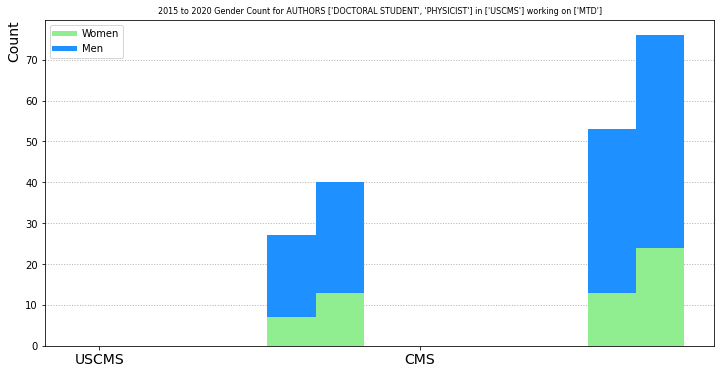

In [46]:
#@markdown ### Visualize the filtered statistics by year

width = 0.9 / len( years.value )
if countries_label == "NONE":
  x = np.arange( 2 )
else: 
  x = np.arange( 3 )

plt.figure( figsize = (6 * len(x) ,6) )
ax = plt.subplot(111)

for i, year in enumerate( list( years.value ) ):
    ax.bar( x + width * i, list( count[ year ][ "FEMALE" ].values() )[-len(x):], width,
           color = "lightgreen", zorder=3 )
    ax.bar( x + width * i, list( count[ year ][ "MALE" ].values() )[-len(x):], width,
           bottom = list( count[ year ][ "FEMALE" ].values() )[-len(x):],
           color = "dodgerblue", zorder=3 )

    
ax.set_title( "{} to {} Gender Count for {} {} in {} working on {}".format( 
    years.value[0], years.value[-1],
    [ str(key) for key in author_legend if list( author.value ) == author_legend[ key ] ][0], 
    list(activities.value), list(countries.value) + ["USCMS"], list(projects.value)
), fontsize = 8 )
ax.set_ylabel( "Count", y = 1.0, ha = "right", fontsize = 14 )
ax.set_xticks( x )
ax.set_xticklabels( [ countries_label, "USCMS", "CMS" ][-len(x):], fontsize = 14 )

custom_legend = [
  Line2D( [0], [0], color = "lightgreen", lw = 5 ),
  Line2D( [0], [0], color = "dodgerblue", lw = 5 )
]
ax.legend( custom_legend, [ "Women", "Men" ], loc = 2 )

ax.set_facecolor("white")
ax.grid( b=True, which="major", axis="y", color = [0.7,0.7,0.7], 
        linestyle = ":", linewidth = 1, zorder=0)
plt.show()